<a href="https://colab.research.google.com/github/Tejaswini170104/CH5020-Term-paper-presentation/blob/main/cartpole_v1_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run 1, Episode 0: Total Reward = 25.0, Tau = 1.0000
Run 1, Episode 100: Total Reward = 13.0, Tau = 0.9901
Run 1, Episode 200: Total Reward = 136.0, Tau = 0.9861
Run 1, Episode 300: Total Reward = 165.0, Tau = 0.9830
Run 1, Episode 400: Total Reward = 220.0, Tau = 0.9804
Run 1, Episode 500: Total Reward = 213.0, Tau = 0.9781
Run 1, Episode 600: Total Reward = 123.0, Tau = 0.9761
Run 1, Episode 700: Total Reward = 213.0, Tau = 0.9742
Run 1, Episode 800: Total Reward = 165.0, Tau = 0.9725
Run 1, Episode 900: Total Reward = 160.0, Tau = 0.9709
Run 1, Episode 1000: Total Reward = 143.0, Tau = 0.9693
Run 1, Episode 1100: Total Reward = 25.0, Tau = 0.9679
Run 1, Episode 1200: Total Reward = 83.0, Tau = 0.9665
Run 1, Episode 1300: Total Reward = 237.0, Tau = 0.9652
Run 1, Episode 1400: Total Reward = 174.0, Tau = 0.9639
Run 1, Episode 1500: Total Reward = 271.0, Tau = 0.9627
Run 1, Episode 1600: Total Reward = 115.0, Tau = 0.9615
Run 1, Episode 1700: Total Reward = 188.0, Tau = 0.9604
Run 1, E

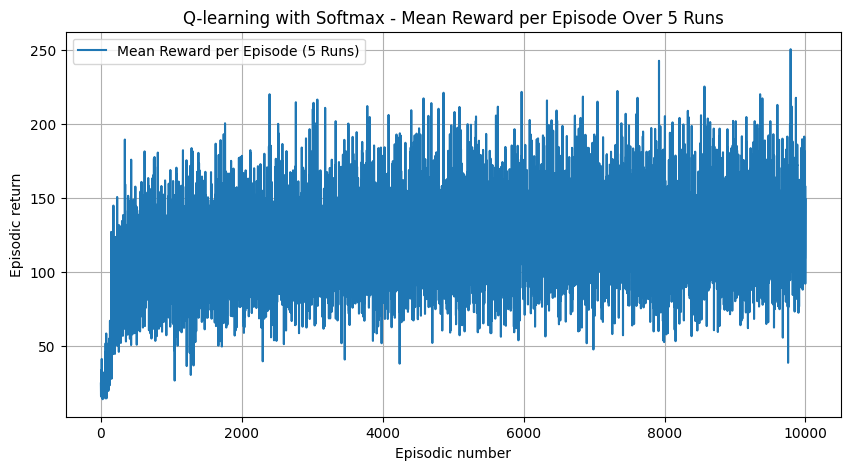

In [ ]:
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt

# Constants
GAMMA = 0.99
TAU_START = 1.0  # Initial temperature
TAU_MIN = 0.05   # Minimum temperature to maintain exploration
TAU_DECAY_RATE = 0.001  # Decay rate for softmax temperature
MAX_EPISODES = 10000
MAX_STEPS = 500
SOLVED_CRITERIA = 500
NUM_RUNS = 5  # Running the experiment 5 times

# Default hyperparameters
ALPHA = 0.1
NUM_BINS = [20, 20, 20, 20]  # Number of bins for each state variable

# State bounds for normalization
state_bounds = [
    [-4.8, 4.8],  # Cart position
    [-3.0, 3.0],  # Cart velocity
    [-0.418, 0.418],  # Pole angle
    [-3.0, 3.0]   # Pole angular velocity
]

def discretize_state(state):
    """Discretize state into bins for tile coding."""
    bin_indices = []
    for i in range(len(state)):
        # Convert state into bin index
        bin_width = (state_bounds[i][1] - state_bounds[i][0]) / NUM_BINS[i]
        bin_index = int((state[i] - state_bounds[i][0]) / bin_width)
        bin_index = min(NUM_BINS[i] - 1, max(0, bin_index))  # Keep within bounds
        bin_indices.append(bin_index)
    return tuple(bin_indices)

def softmax_action(q_table, state, tau):
    """Select action using Softmax exploration strategy."""
    if state not in q_table:
        q_table[state] = [0, 0]  # Initialize action values

    # Ensure tau is not too small
    tau = max(TAU_MIN, tau)

    q_values = np.array(q_table[state])
    exp_q = np.exp((q_values - np.max(q_values)) / tau)  # Prevent overflow
    probs = exp_q / np.sum(exp_q)

    # Handle NaN cases (rare but possible due to numerical issues)
    if np.isnan(probs).any() or np.sum(probs) == 0:
        probs = np.ones_like(q_values) / len(q_values)  # Uniform probabilities

    return np.random.choice(len(q_values), p=probs)

def qlearning_softmax(env, alpha, tau_decay, run_num):
    """Q-learning with Softmax exploration using discretized bins."""
    q_table = {}  # Dictionary for sparse Q-table
    rewards_per_episode = []
    tau = TAU_START  # Initialize temperature

    for episode in range(MAX_EPISODES):
        state = discretize_state(env.reset()[0])
        total_reward = 0

        for _ in range(MAX_STEPS):
            action = softmax_action(q_table, state, tau)
            next_state_raw, reward, terminated, truncated, _ = env.step(action)
            next_state = discretize_state(next_state_raw)

            best_next_action = np.argmax(q_table.get(next_state, [0, 0]))
            td_target = reward + (GAMMA * q_table.get(next_state, [0, 0])[best_next_action] if not (terminated or truncated) else 0)

            if state not in q_table:
                q_table[state] = [0, 0]  # Initialize action values
            q_table[state][action] += alpha * (td_target - q_table[state][action])

            state = next_state
            total_reward += reward
            if terminated or truncated:
                break

        rewards_per_episode.append(total_reward)

        # Decay tau (Inverse square root decay)
        tau = max(TAU_MIN, TAU_START / (1 + tau_decay * episode**0.5))

        # Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"Run {run_num + 1}, Episode {episode}: Total Reward = {total_reward}, Tau = {tau:.4f}")

    return rewards_per_episode

def train():
    """Train Q-learning with Softmax and plot mean rewards."""
    all_rewards = np.zeros((NUM_RUNS, MAX_EPISODES))

    for run in range(NUM_RUNS):
        env = gym.make("CartPole-v1")
        rewards = qlearning_softmax(env, ALPHA, TAU_DECAY_RATE, run)
        all_rewards[run, :] = rewards  # Store rewards for this run

    # Compute mean reward per episode across 5 runs
    mean_rewards = np.mean(all_rewards, axis=0)

    # Plot mean rewards
    plt.figure(figsize=(10, 5))
    plt.plot(mean_rewards, label="Mean Reward per Episode (5 Runs)")
    plt.xlabel("Episodic number")
    plt.ylabel("Episodic return")
    plt.title("Q-learning with Softmax - Mean Reward per Episode Over 5 Runs")
    plt.legend()
    plt.grid()
    plt.show()

# Start training
train()
